In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import datasets
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import psycopg2
from yellowbrick.cluster import KElbowVisualizer
import sqlalchemy as sqlalc
import folium
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import numpy as np

In [2]:
#conn  =  psycopg2.connect(database= 'Criminalidade',user = 'postgres',password = '123456')
conn  =  psycopg2.connect(host = 'postgres10-crime_sp', database = 'postgres', user = 'postgres', password = 'senha')

In [3]:
df = pd.read_sql_query("""select dim_local.latitude,
    dim_local.longitude, 
    dim_pessoa2.id_cor_cutis 
    from fato_crime
    inner join dim_rubrica2
    on dim_rubrica2.id_dim_rubrica = fato_crime.rubrica
    inner join dim_pessoa2
    on fato_crime.pessoa = dim_pessoa2.id_dim_pessoa
    inner join dim_local
    on fato_crime.local = dim_local.id_dim_local
    inner join dim_data
    on fato_crime.data = dim_data.id_dim_data
    where dim_rubrica2.grupo_rubrica = 'homicidio' and 
    dim_pessoa2.descr_tipo_pessoa = 'Vítima' and 
    dim_pessoa2.flag_vitima_fatal = 'S' 
    and (dim_local.latitude <> 0)""",conn)

In [4]:
df.describe()

latitude    longitude  id_cor_cutis
count  3979.000000  3979.000000   3979.000000
mean    -23.577325   -46.622734      1.771551
std       0.092655     0.115432      1.156586
min     -23.899783   -46.818614      0.000000
25%     -23.643723   -46.715558      1.000000
50%     -23.559754   -46.645169      2.000000
75%     -23.508765   -46.533096      2.000000
max     -23.374155   -46.367421      5.000000

In [5]:
df_original = df

In [6]:
df_original.head()

latitude  longitude  id_cor_cutis
0 -23.627636 -46.699155             2
1 -23.680454 -46.713148             1
2 -23.684177 -46.709788             2
3 -23.650387 -46.705067             2
4 -23.698062 -46.782700             2

In [8]:
df = df/df.max()

In [9]:
df.head()

latitude  longitude  id_cor_cutis
0  1.010845   1.007154           0.4
1  1.013104   1.007456           0.2
2  1.013263   1.007384           0.4
3  1.011818   1.007282           0.4
4  1.013858   1.008956           0.4

In [7]:
xrm = df.loc[:,["longitude","latitude", "id_cor_cutis"]].values

Text(0,0.5,'latitude')

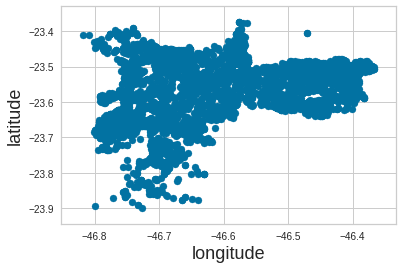

In [8]:
plt.scatter(xrm[:,0], xrm[:,1], cmap='gist_rainbow')
plt.xlabel('longitude', fontsize=18)
plt.ylabel('latitude', fontsize=18)

In [11]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10),timings=True)
elbow = df[['latitude','longitude', 'id_cor_cutis']]
elbow.head()

latitude  longitude  id_cor_cutis
0 -23.627636 -46.699155             2
1 -23.680454 -46.713148             1
2 -23.684177 -46.709788             2
3 -23.650387 -46.705067             2
4 -23.698062 -46.782700             2

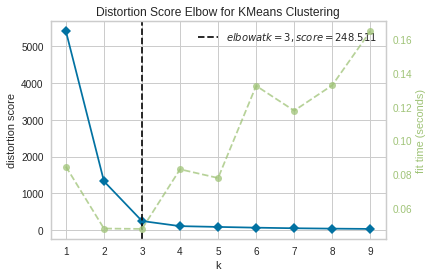

In [12]:
visualizer.fit(elbow) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure

In [13]:
km = KMeans(n_clusters = visualizer.elbow_value_)
km.fit(xrm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [14]:
new_labels = km.labels_
new_labels

array([2, 1, 2, ..., 2, 1, 2], dtype=int32)

Text(0.5,1,'Com agrupamento')

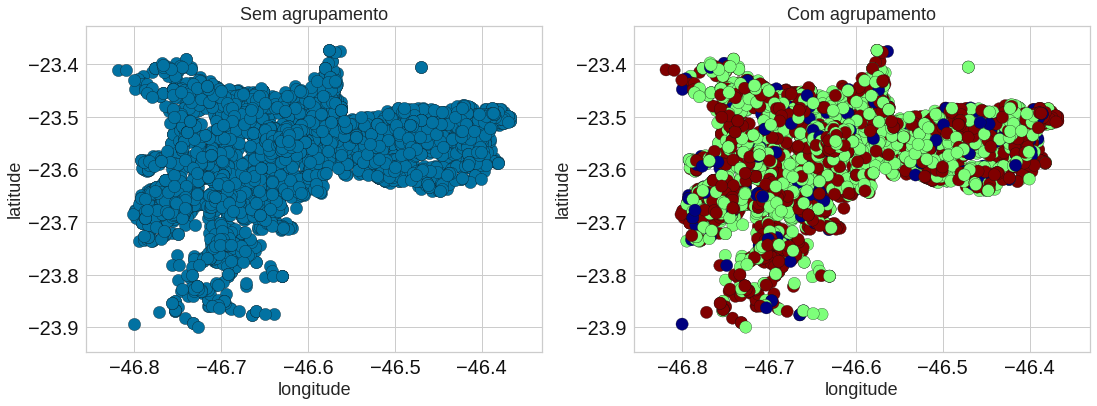

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(18,6))
axes[0].scatter(xrm[:, 0], xrm[:, 1], cmap='gist_rainbow',
edgecolor='k', s=150)
axes[1].scatter(xrm[:, 0], xrm[:, 1], c=new_labels, cmap='jet',
edgecolor='k', s=150)
axes[0].set_xlabel('longitude', fontsize=18)
axes[0].set_ylabel('latitude', fontsize=18)
axes[1].set_xlabel('longitude', fontsize=18)
axes[1].set_ylabel('latitude', fontsize=18)
axes[0].tick_params(direction='in', length=10, width=5, colors='k', labelsize=20)
axes[1].tick_params(direction='in', length=10, width=5, colors='k', labelsize=20)
axes[0].set_title('Sem agrupamento', fontsize=18)
axes[1].set_title('Com agrupamento', fontsize=18)

In [17]:
xrm

array([[ 1.00715446,  1.0108445 ,  0.4       ],
       [ 1.00745624,  1.01310417,  0.2       ],
       [ 1.00738378,  1.01326346,  0.4       ],
       ..., 
       [ 1.00694989,  1.01337811,  0.2       ],
       [ 1.00552291,  1.00737796,  0.2       ],
       [ 1.00592252,  1.01165135,  0.4       ]])

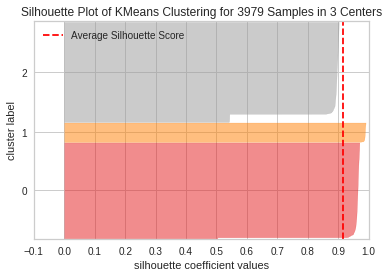

In [18]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
model = SilhouetteVisualizer(km)
model.fit(xrm)
model.show()

In [19]:
model.silhouette_score_

0.91702510062849807

In [20]:
# -*- coding: utf-8 -*-
__author__ = "Joaquim Viegas"

""" JQM_CV - Python implementations of Dunn and Davis Bouldin clustering validity indices
dunn(k_list):
    Slow implementation of Dunn index that depends on numpy
    -- basec.pyx Cython implementation is much faster but flower than dunn_fast()
dunn_fast(points, labels):
    Fast implementation of Dunn index that depends on numpy and sklearn.pairwise
    -- No Cython implementation
davisbouldin(k_list, k_centers):
    Implementation of Davis Boulding index that depends on numpy
    -- basec.pyx Cython implementation is much faster
"""

import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

def delta(ck, cl):
    values = np.ones([len(ck), len(cl)])*10000
    
    for i in range(0, len(ck)):
        for j in range(0, len(cl)):
            values[i, j] = np.linalg.norm(ck[i]-cl[j])
            
    return np.min(values)
    
def big_delta(ci):
    values = np.zeros([len(ci), len(ci)])
    
    for i in range(0, len(ci)):
        for j in range(0, len(ci)):
            values[i, j] = np.linalg.norm(ci[i]-ci[j])
            
    return np.max(values)
    
def dunn(k_list):
    """ Dunn index [CVI]
    
    Parameters
    ----------
    k_list : list of np.arrays
        A list containing a numpy array for each cluster |c| = number of clusters
        c[K] is np.array([N, p]) (N : number of samples in cluster K, p : sample dimension)
    """
    deltas = np.ones([len(k_list), len(k_list)])*1000000
    big_deltas = np.zeros([len(k_list), 1])
    l_range = list(range(0, len(k_list)))
    
    for k in l_range:
        for l in (l_range[0:k]+l_range[k+1:]):
            deltas[k, l] = delta(k_list[k], k_list[l])
        
        big_deltas[k] = big_delta(k_list[k])

    di = np.min(deltas)/np.max(big_deltas)
    return di

def delta_fast(ck, cl, distances):
    values = distances[np.where(ck)][:, np.where(cl)]
    values = values[np.nonzero(values)]

    return np.min(values)
    
def big_delta_fast(ci, distances):
    values = distances[np.where(ci)][:, np.where(ci)]
    #values = values[np.nonzero(values)]
            
    return np.max(values)

def dunn_fast(points, labels):
    """ Dunn index - FAST (using sklearn pairwise euclidean_distance function)
    
    Parameters
    ----------
    points : np.array
        np.array([N, p]) of all points
    labels: np.array
        np.array([N]) labels of all points
    """
    distances = euclidean_distances(points)
    ks = np.sort(np.unique(labels))
    
    deltas = np.ones([len(ks), len(ks)])*1000000
    big_deltas = np.zeros([len(ks), 1])
    
    l_range = list(range(0, len(ks)))
    
    for k in l_range:
        for l in (l_range[0:k]+l_range[k+1:]):
            deltas[k, l] = delta_fast((labels == ks[k]), (labels == ks[l]), distances)
        
        big_deltas[k] = big_delta_fast((labels == ks[k]), distances)

    di = np.min(deltas)/np.max(big_deltas)
    return di
    
    
def  big_s(x, center):
    len_x = len(x)
    total = 0
        
    for i in range(len_x):
        total += np.linalg.norm(x[i]-center)    
    
    return total/len_x

def davisbouldin(k_list, k_centers):
    """ Davis Bouldin Index
    
    Parameters
    ----------
    k_list : list of np.arrays
        A list containing a numpy array for each cluster |c| = number of clusters
        c[K] is np.array([N, p]) (N : number of samples in cluster K, p : sample dimension)
    k_centers : np.array
        The array of the cluster centers (prototypes) of type np.array([K, p])
    """
    len_k_list = len(k_list)
    big_ss = np.zeros([len_k_list], dtype=np.float64)
    d_eucs = np.zeros([len_k_list, len_k_list], dtype=np.float64)
    db = 0    

    for k in range(len_k_list):
        big_ss[k] = big_s(k_list[k], k_centers[k])

    for k in range(len_k_list):
        for l in range(0, len_k_list):
            d_eucs[k, l] = np.linalg.norm(k_centers[k]-k_centers[l])

    for k in range(len_k_list):
        values = np.zeros([len_k_list-1], dtype=np.float64)
        for l in range(0, k):
            values[l] = (big_ss[k] + big_ss[l])/d_eucs[k, l]
        for l in range(k+1, len_k_list):
            values[l-1] = (big_ss[k] + big_ss[l])/d_eucs[k, l]

        db += np.max(values)
    res = db/len_k_list
    return res

In [21]:
y_pred = km.predict(xrm)
res =  pd.concat([pd.DataFrame(xrm),pd.DataFrame(new_labels)], axis=1)
res.columns = ['long','lat', 'id_cor_cutis', 'cluster']


# We store the clusters 
clus0 = res.loc[res['cluster'] == 0] 
clus1 = res.loc[res['cluster'] == 1] 
clus2 = res.loc[res['cluster'] == 2] 
cluster_list = [clus0.values, clus1.values, clus2.values] 
  
print(dunn(cluster_list)) 

5.06664914798


In [23]:
xrm2 = df_original.loc[:,["longitude","latitude", "id_cor_cutis"]].values

In [24]:
res =  pd.concat([pd.DataFrame(xrm2),pd.DataFrame(new_labels)], axis=1)
res.columns = ['long','lat', 'id_cor_cutis', 'cluster']

In [25]:
res.head()

long        lat  id_cor_cutis  cluster
0 -46.699155 -23.627636           2.0        0
1 -46.713148 -23.680454           1.0        2
2 -46.709788 -23.684177           2.0        0
3 -46.705067 -23.650387           2.0        0
4 -46.782700 -23.698062           2.0        0

In [26]:
res.groupby(by=['cluster','id_cor_cutis']).count()

long   lat
cluster id_cor_cutis            
0       2.0           1752  1752
        3.0             20    20
1       4.0              3     3
        5.0            355   355
2       0.0            151   151
        1.0           1698  1698

In [27]:
m = folium.Map(
    location=[-23.550341, -46.622445],
    zoom_start=11,
    
)


tooltip = 'Click me!'
for i in range(len(res)):
    teste = 'pardos e amarelos'
    cor = 'green'
    if res['cluster'][i]== 0:
        folium.Circle(
        radius=10,
        location=[res['lat'][i],res['long'][i]],
        popup='The Waterfront',
        color=cor,
        fill=False,
        ).add_to(m)


m

In [28]:
m = folium.Map(
    location=[-23.550341, -46.622445],
    zoom_start=11,
    
)


tooltip = 'Click me!'
for i in range(len(res)):
    teste = 'pretos e vermelhos'
    cor = 'black'
    if res['cluster'][i]== 1:
        folium.Circle(
        radius=10,
        location=[res['lat'][i],res['long'][i]],
        popup='The Waterfront',
        color=cor,
        fill=False,
        ).add_to(m)


m

In [29]:
m = folium.Map(
    location=[-23.550341, -46.622445],
    zoom_start=11,
    
)


tooltip = 'Click me!'
for i in range(len(res)):
    teste = 'bracos e outros'
    cor = 'blue'
    if res['cluster'][i]== 2:
        folium.Circle(
        radius=10,
        location=[res['lat'][i],res['long'][i]],
        popup='The Waterfront',
        color=cor,
        fill=False,
        ).add_to(m)


m